# Active RL experiment progress report

We're looking at Reinforcement learning in Tabular MDPs.
In our setting, rewards are only observed when the agent makes a decision to query them (paying some cost to do so).
In order to maximize performance (measured as returns minus total query cost), the agent must intelligently chose when to make these queries.

We call the module which decides when to query a "query function".  So far, we focus on a simple heuristic query function ("Query first n visits") which queries any state-action which has not already been queried n times, where n is a hyper-parameter.  

We propose two ways of tuning this hyperparameter and demonstrate their potential in preliminary experiments. 
Note that tuning n by running multiple experiments in the environment is assumed not to be an option in our motivating set-up, since this would impose real costs (both in terms of queries, and, potentially, rewards).

## Environment
We've been experimenting with gridworld and chain environments. 
The chain environment is used by Ian Osband in this paper:
https://arxiv.org/abs/1607.00215

In this environment, the agent must explore a long chain of states, only the last of which has positive expected reward.  

Our code is available in a fork of Ian's repo: 
https://github.com/capybaralet/TabulaRL

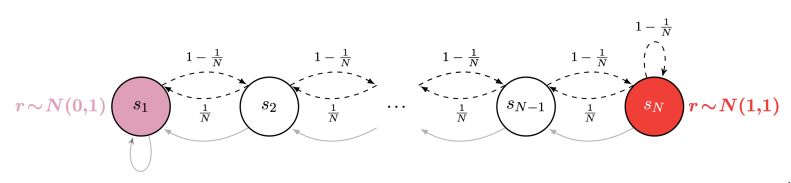

In [51]:
# Here is a diagram of the environment, taken for Ian's paper
# Rewards for intermediate states are deterministically 0.
# There are two actions (right and left), the right action stochastically fails, while the left action always succeeds.

from IPython.display import Image
Image("figures/chain_figure.png")


In [35]:
# Here is the implementation of the chain environment:

from TabulaRL.environment import TabularMDP
def make_stochasticChain(chainLen, max_reward=1):
    nState = chainLen
    epLen = chainLen
    nAction = 2
    pNoise = 1. / chainLen

    R_true = {}
    P_true = {}
    for s in xrange(nState):
        for a in xrange(nAction):
            R_true[s, a] = (0, 0)
            P_true[s, a] = np.zeros(nState)

    # Rewards (the start and end state rewards are stochastic, all others are determinstically 0.)
    R_true[0, 0] = (0, 1)
    R_true[nState - 1, 1] = (max_reward, 1)

    # Transitions 
    for s in xrange(nState):
        P_true[s, 0][max(0, s-1)] = 1.

        # the forward action doesn't always succeed:
        P_true[s, 1][min(nState - 1, s + 1)] = 1. - pNoise
        P_true[s, 1][max(0, s-1)] += pNoise

    stochasticChain = TabularMDP(nState, nAction, epLen)
    stochasticChain.R = R_true
    stochasticChain.P = P_true
    stochasticChain.reset()
    return stochasticChain


## Our experiments

Our experiments so far aim at testing the validity of a few of our ideas (and their implementations).

We'll present results for the chain of length 5.
Following Osband, we use some version of PSRL in all of our experiments.
We run 3000 experiments for each algorithm, and plot average performance.  

We compared across a wide range of query costs and horizons (i.e. the numer of episodes).  For presentation purposes, we only plot 3 representative query costs (low, medium, and high), and 2 horizons (short and long).  For lower query costs (and longer horizons), the agent should benefit from querying many times, whereas for higher costs (and shorter horizons), the best strategy may to query only once, or never.



# Idea 1: 
Since the reason PSRL samples environments is to encourage exploration, and we may stop querying (state, action) pairs at some point, we propose "clamping" sampled rewards to equal the expected reward for any such (s,a).  

## Experiment 1
Our first experiment verifies that this improves performance.
We simply compare standard PSRL (green) with the proposed modification (blue) in the chain environment with 5 states.


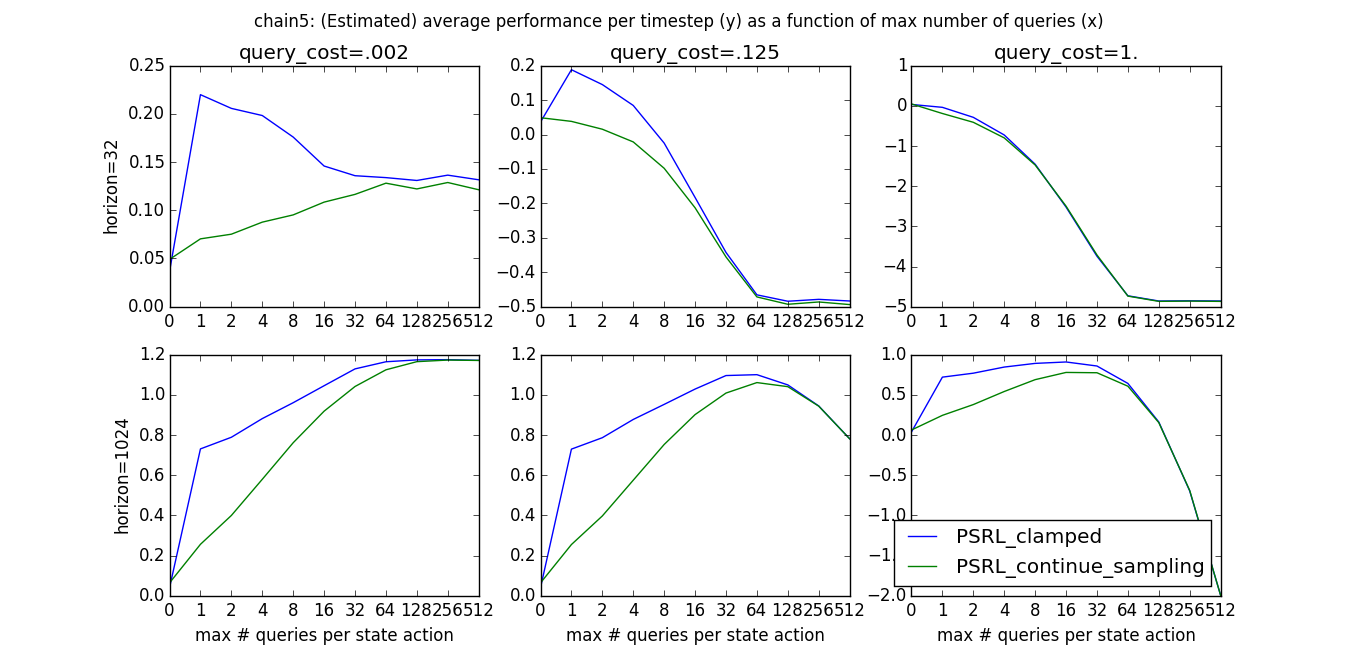

In [36]:
from IPython.display import Image
Image("figures/PSRL_clamped_chain5.png")

## Idea 2: 

In order to tune the value of n, we propose evaluating different values of n in environments sampled from the agent's posterior, and chosing the n with the best average performance in these experiments; we call this algorithm "simulated query rollouts (SQR)".  

We consider an approximate version of SQR ("ASQR"). Instead of actually running experiments in the sampled environments (which can be prohibitively costly), ASQR instead:
1. Samples an environment, E, from the agents posterior
2. Performs all N queries of each (s,a) off-line without acting in E
3. Updates the agent's posterior based on the results of these queries
4. Finds the expected environment, E', based on this updated posterior
5. Uses planning to find the optimal policy for E', and computes the expected return of running this policy in E
6. Selects the N with the best performance (= expected return - cost of queries).

We evaluate both of these algorithms as well, and show that their estimates of the best n do not deviate drastically from the best n found by hyper-parameter search.  


For a more thorough description of SQR and ASQR, see: https://github.com/capybaralet/TabulaRL/blob/master/tex/Choosing%20Which%20Queries%20to%20Make.pdf

Note that SQR and ASQR are not limited to the "Query first n times" query function.  In fact, we can generalize SQR to select any query function from a finite set, whereas we can generalize ASQR to any query function whose query decisions only depend on the history of queries (and the resulting observations of reward).

## Experiment 2

To evaluate the ability of (A)SQR to chose a sensible value of n for the "Query first n visits" heuristic, we compare  the performance for different values of n in the real environment, with the *estimated* performance of (A)SQR *in sampled environments*.  If (A)SQR would select a value of n which is close to the best value (as measured by average performance in the real environment), that means it would be a suitable method for chosing a value of n to use in the real environment.

To be precise, in this experiment, we sample 3000 environments, and run (A)SQR in each sampled environment.  (A)SQR returns an estimate of performance in each environment (for each n).  The algorithms typically progress by finding the n with the highest estimated performance (averaged across sampled environments), but instead we just plot the estimates of performance for different ns, to see how similar their shape is to the true performance achieved for the same values of n.

These plots show that, although the exptected returns differ in the sampled environments, (A)SQR selects values of n that are close to the true best value and whose performance is not significantly worse.  This demonstrates that (A)SQR are promising approaches to selecting a query function.





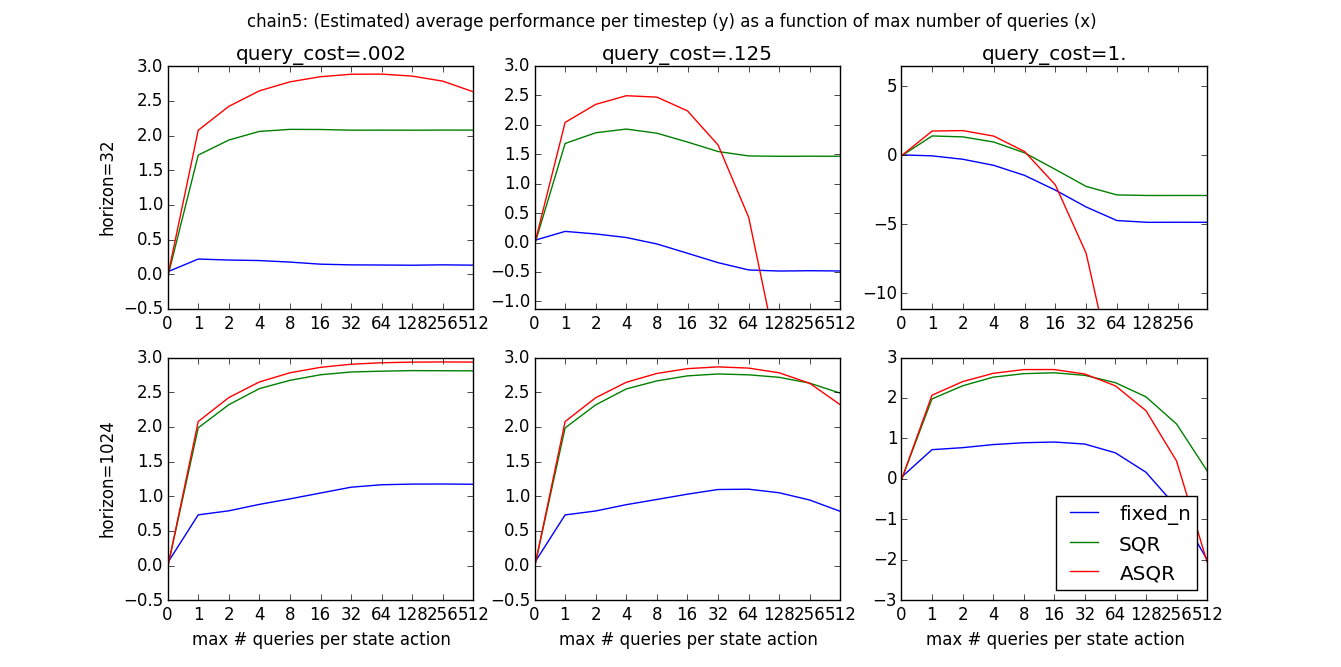

In [45]:
Image("figures/SQR_ASQR_chain5.png")

## Experiment 2 (continued) (TODO: make plot)

To further analyze the performance of (A)SQR, we plot the difference between the *actual* performance achieved with the best n (tuned in the real environment) and the n selected by running (A)SQR.

We use bootstrapping to estimate the average performance of (A)SQR using different numbers of sampled environments.

These experiments allow us to compare the performance of ASQR vs. SQR, and give a sense of how many environment samples are needed in order to achieve good performance with these algorithms.  We find that ASQR and SQR perform comperably, and are able to reliably identify the best n with ~1000 samples, but even a single sample performs reasonably well.

(Note that performance here will depend on the horizon and query cost; we only show results for horizon=1024, query_cost=.125)


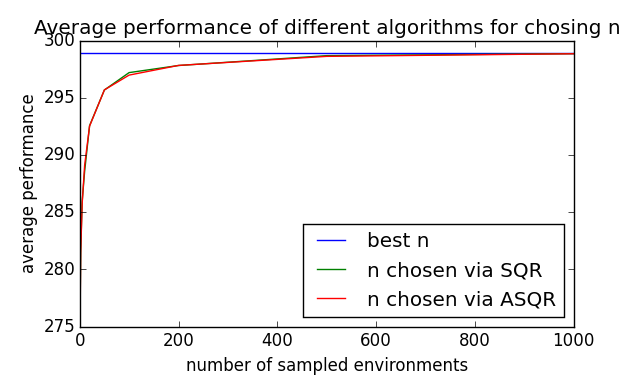

In [52]:
Image("figures/performance_SQR_ASQR.png")

# Experiment Code
Here, we include a stripped-down version of the script we use to run these experiments (dk_exp_script.py). 

In [43]:
# %load dk_exp_script.py
import numpy as np

# these imports are from our fork of Ian Osband's code base
import TabulaRL.gridworld as gridworld
import TabulaRL.query_functions as query_functions
import TabulaRL.finite_tabular_agents as finite_tabular_agents
from TabulaRL.feature_extractor import FeatureTrueState
from TabulaRL.environment import make_stochasticChain


#-----------------------------------------------------------------------------------
# USEFUL FUNCTIONS

def is_power2(num):
    '''states if a number is a power of two'''
    return num != 0 and ((num & (num - 1)) == 0)

def sample_gaussian(loc, scale, shape):
    """ Sample a gaussian (handles variance=0)"""
    if scale == 0:
        return loc * np.ones(shape)
    else:
        return np.random.normal(loc, scale, shape)

#-----------------------------------------------------------------------------------
# SETUP 
# (chose an algorithm)
algorithm='fixed_n'  
algorithm='SQR'  
algorithm='ASQR'  

num_experiments=20
query_cost = .125

# select which values of n to try (powers of 2)
log_n_max=10
n_max = 2**log_n_max
ns = np.hstack((np.array([0,]), 2**np.arange(log_n_max)))

# select which horizons to evaluate (powers of 2)
log_num_episodes=10
num_episodes_remaining = 2**log_num_episodes


# ENVIRONMENT
chain_len = 5
epLen = chain_len
initial_env = make_stochasticChain(chain_len, max_reward=((chain_len - 1.)/chain_len)**-chain_len)
f_ext = FeatureTrueState(initial_env.epLen, initial_env.nState, initial_env.nAction, initial_env.nState)

# AGENT
alg = finite_tabular_agents.PSRLLimitedQuery
initial_agent = alg(env.nState, env.nAction, env.epLen, P_true=None, R_true=None)

# RUN EXPERIMENTS

# record results here:
num_queries = np.empty((num_experiments, log_num_episodes+1, log_n_max+1))
returns = np.empty((num_experiments, log_num_episodes+1, log_n_max+1))


for kk in range(num_experiments):
    print "beginning experiment #", kk
    env = copy.deepcopy(initial_env)

    if algorithm in ['SQR', 'ASQR']: # use a sampled environment
        sampled_R, sampled_P = initial_agent.sample_mdp()
        env.R = {kk:(sampled_R[kk], 1) for kk in sampled_R}
        env.P = sampled_P

    # We use the same reward samples for different values of n to reduce variance 
    sampled_rewards = {(s,a) : sample_gaussian(env.R[s,a][0], env.R[s,a][1], n_max) for (s,a) in env.R.keys()}
    first_n_sampled_rewards = [{sa: sampled_rewards[sa][:n] for sa in sampled_rewards} for n in range(n_max + 1)]

    for ind, n in enumerate(ns):
        # reset the agent when trying a new value of n
        agent = copy.deepcopy(initial_agent)
        query_function = query_functions.QueryFirstNVisits(query_cost, n)
        query_function.setAgent(agent)

        if algorithm=="ASQR": # update posterior, compute expected returns
            updated_R = {}
            for [s,a] in first_n_sampled_rewards[n]:
                mu0, tau0 = agent.R_prior[s,a]
                num_samples = len(first_n_sampled_rewards[n][s,a])
                tau1 = tau0 + agent.tau * num_samples
                mu1 = (mu0 * tau0 + sum(first_n_sampled_rewards[n][s,a]) * agent.tau) / tau1
                updated_R[s,a] = mu1
            updated_P = sampled_P
            expected_returns = agent.compute_qVals_true(updated_R, updated_P, sampled_R, sampled_P)[0]
            returns[kk, :, ind] = expected_returns * 2**np.arange(log_num_episodes+1)
            num_queries[kk, :, ind] = n * sum([agent.query_function.will_query(s,a) for [s,a] in first_n_sampled_rewards[n]])

        else: # Run an experiment 
            nEps = num_episodes_remaining
            # --------------- modified from dk_run_finite_tabular_experiment ------------------
            qVals, qMax = env.compute_qVals()
            cumReward = 0
            cumQueryCost = 0 
            for ep in xrange(1, nEps + 2):
                env.reset()
                epMaxVal = qMax[env.timestep][env.state]
                agent.update_policy(ep)

                pContinue = 1
                while pContinue > 0:
                    # Step through the episode
                    h, oldState = f_ext.get_feat(env)

                    action = agent.pick_action(oldState, h)
                    # chose to query or not (and record the cost)
                    query, queryCost = agent.query_function(oldState, action, ep, h)
                    cumQueryCost += queryCost

                    reward, newState, pContinue = env.advance(action)
                    if query and first_n_sampled_rewards[n] is not None: # use pre-sampled rewards
                        reward = first_n_sampled_rewards[n][oldState, action][agent.query_function.visit_count[oldState, action] - 1]
                    cumReward += reward 
                    agent.update_obs(oldState, action, reward, newState, pContinue, h, query)

                if is_power2(ep): # checkpoint
                    returns[kk, int(np.log2(ep)), ind] = cumReward
                    num_queries[kk, int(np.log2(ep)), ind] = cumQueryCost / query_cost

            # ---------------------------------------------------------------------
            
print 'avg num_queries for 1024 episodes and increasing values of N'
print num_queries.mean(0)[-1]
print 'avg returns for 1024 episodes and increasing values of N'
print returns.mean(0)[-1]
print 'avg performance for 1024 episodes and increasing values of N'
print returns.mean(0)[-1] - num_queries.mean(0)[-1] * query_cost





beginning experiment # 0
beginning experiment # 1
beginning experiment # 2
beginning experiment # 3
beginning experiment # 4
beginning experiment # 5
beginning experiment # 6
beginning experiment # 7
beginning experiment # 8
beginning experiment # 9
beginning experiment # 10
beginning experiment # 11
beginning experiment # 12
beginning experiment # 13
beginning experiment # 14
beginning experiment # 15
beginning experiment # 16
beginning experiment # 17
beginning experiment # 18
beginning experiment # 19
avg num_queries for 1024 episodes and increasing values of N
[    0.    10.    20.    40.    80.   160.   320.   640.  1280.  2560.
  5120.]
avg returns for 1024 episodes and increasing values of N
[  -66.79721298  3390.08904467  3428.24292641  4029.07089844  3940.09711952
  4108.74866409  4139.18537064  4163.91526184  4165.66488342  4166.02812805
  4168.36263733]
avg performance for 1024 episodes and increasing values of N
[  -66.79721298  3388.83904467  3425.74292641  4024.07089844  

In [26]:
print returns.shape

(20, 11, 11)
